<a href="https://colab.research.google.com/github/john-hafner/PHY451-GammaRay/blob/main/PHY451_Gamma_Ray_Attenuation_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lead Attenuation Data
Our original approach turned out to be wrong

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
# Loading data saved from github, apparently really needed that '?raw=true' at the end.
data_path = 'https://github.com/john-hafner/PHY451-GammaRay/blob/a23eb6b9f4ca4b44d4d534028e3fc4c746cda33c/data/attenuation.xlsx?raw=true'
df = pd.read_excel(data_path, index_col=None)
df.head()

,material,thickness (cm),count
0,none,0.00000,787
1,none,0.00000,771
2,none,0.00000,737
3,none,0.00000,764
4,lead,0.61725,439


In [173]:
# Use another value for the thickness.  It does make X^2 worse, from 7.6 to 10.6!

# df.iloc[-4:, 1] = 10.33725
# df.tail(5)

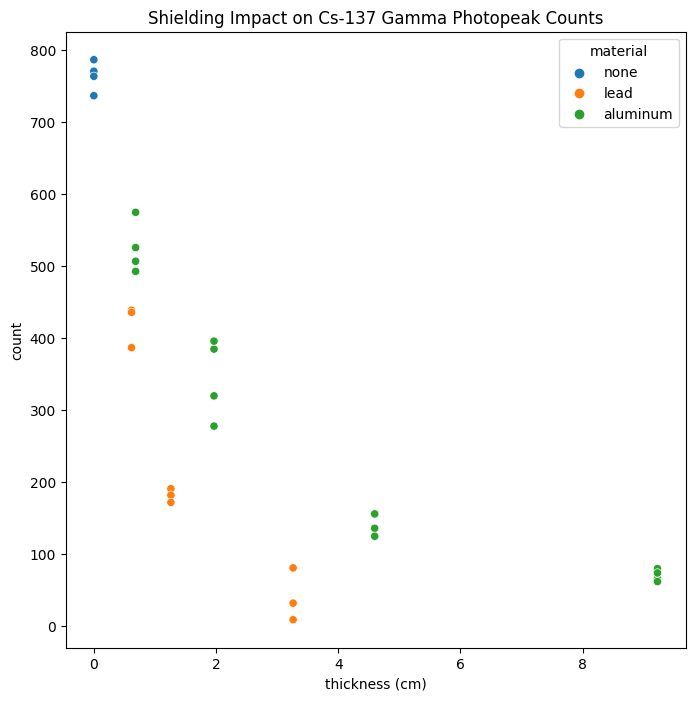

In [174]:

plt.figure(figsize=(8,8))

sns.scatterplot(df, x='thickness (cm)', y='count', hue='material')

plt.title('Shielding Impact on Cs-137 Gamma Photopeak Counts')
plt.show()

In [175]:
df.loc[:, 'log_count'] = np.log(df['count'])
df.loc[:, 'unc_count'] = np.sqrt(df['count'])
df.loc[:, 'unc_log_count'] = df['unc_count'] / df['count']

df.head()

,material,thickness (cm),count,log_count,unc_count,unc_log_count
0,none,0.00000,787,6.668228,28.053520,0.035646
1,none,0.00000,771,6.647688,27.766887,0.036014
2,none,0.00000,737,6.602588,27.147744,0.036835
3,none,0.00000,764,6.638568,27.640550,0.036179
4,lead,0.61725,439,6.084499,20.952327,0.047727


In [176]:
from sklearn.linear_model import LinearRegression

# Lead, we'll include the 'none' material for the base level.
x_pb = np.array(df.loc[df['material'] != 'aluminum', 'thickness (cm)']).reshape(-1,1)
y = np.array(df.loc[df['material'] != 'aluminum', 'log_count']).reshape(-1,1)
model = LinearRegression().fit(x_pb, y)
df.loc[df['material'] == 'lead', 'log_expected'] = model.predict(df.loc[df['material'] == 'lead', 'thickness (cm)'].to_numpy().reshape(-1,1))
pb_hat = model.predict(x_pb)

print('Lead scores:')
print(f'Model coeff: {model.coef_}, and intercept: {model.intercept_}')
print(f'Score: {model.score(x_pb, y)}')

x_al = np.array(df.loc[df['material'] != 'lead', 'thickness (cm)']).reshape(-1,1)
y = np.array(df.loc[df['material'] != 'lead', 'log_count']).reshape(-1,1)
model = LinearRegression().fit(x_al, y)
df.loc[df['material'] == 'aluminum', 'log_expected'] = model.predict(df.loc[df['material'] == 'aluminum', 'thickness (cm)'].to_numpy().reshape(-1,1))
al_hat = model.predict(x_al)

print('Aluminu scores:')
print(f'Model coeff: {model.coef_}, and intercept: {model.intercept_}')
print(f'Score: {model.score(x_al, y)}')


Lead scores:
Model coeff: [[-1.01168991]], and intercept: [6.61075693]
Score: 0.8880301558537472
Aluminu scores:
Model coeff: [[-0.25393845]], and intercept: [6.42562188]
Score: 0.944119426609053


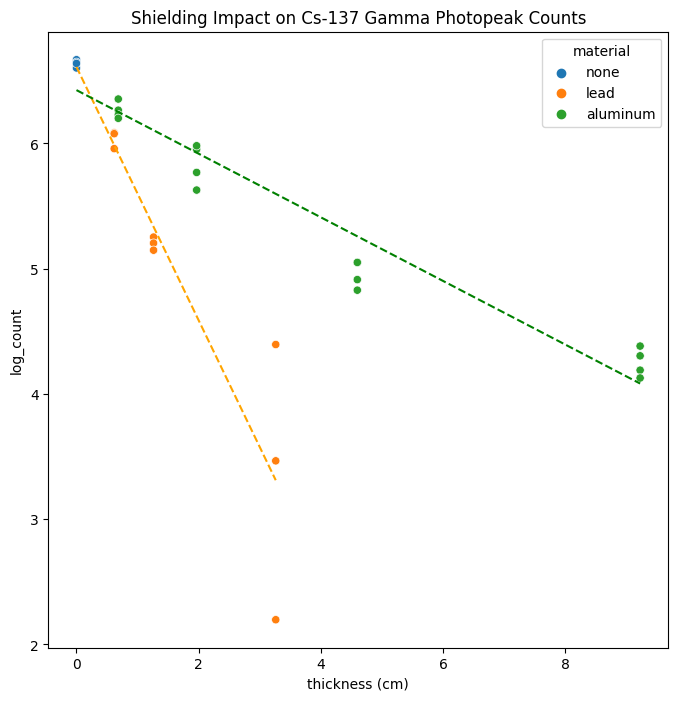

In [177]:
#df.head()
plt.figure(figsize=(8,8))

#sns.scatterplot(df, x='thickness (cm)', y='log_count', hue='material', errorbar=('ci', 95))
sns.scatterplot(df, x='thickness (cm)', y='log_count', hue='material')
plt.plot(x_pb, pb_hat, label='fit - lead', color='orange', linestyle='--')
plt.plot(x_al, al_hat, label='fit - aluminum', color='green', linestyle='--')
#sns.pointplot(data=df, x='thickness (cm)', y='count', hue='material', errorbar=('ci', 95))

plt.title('Shielding Impact on Cs-137 Gamma Photopeak Counts')
plt.show()

In [178]:
n = df.shape[0] - 4 - 2
n

23

In [179]:
print(f"X^2: {1 / 23 * (((df['log_count'] - df['log_expected']) / df['unc_log_count'])**2).sum():.2f}")

X^2: 10.09


So a marked improvement over the original 316 I got.  However this is the full $\chi^2$ for both aluminum and lead.  I can evalulate them separately:

In [180]:
dat = df.loc[df['material'] == 'lead', :]
d = dat.shape[0] - 2
#d = 1
print(f'd = {d}')
print(f"Lead X^2: {1 / d * (((dat['log_count'] - dat['log_expected']) / dat['unc_log_count'])**2).sum():.2f}")
#print(f"Lead X^2: {1 / d * (((dat['log_count'] - dat['log_expected'])**2 / dat['log_expected'])).sum():.2f}")

dat = df.loc[df['material'] == 'aluminum', :]
d = dat.shape[0] - 2
#d = 1
print(f'd = {d}')
print(f"Aluminum X^2: {1 / d * (((dat['log_count'] - dat['log_expected']) / dat['unc_log_count'])**2).sum():.2f}")
#print(f"Aluminum X^2: {1 / d * (((dat['log_count'] - dat['log_expected'])**2 / dat['log_expected'])).sum():.2f}")

d = 7
Lead X^2: 17.94
d = 14
Aluminum X^2: 7.61


So looking at them separately shows that aluminum's model improves a bit, while lead gets worse.  In both cases it does look like the most variance is in the last set of data.  For lead the variance is very high, while for aluminum it appears too high.

There is also another approach of taking each set of measurements for a given thickness and averaging them for the value at that point.  But it would bring up some question on how to propogate the errors.  Originally it's just $\sqrt{x}$ for some $x$.  Do we instead switch to the standard deviation?  Or standard deviation of the mean?  Or simply treat the average as a formula & propogate through that?

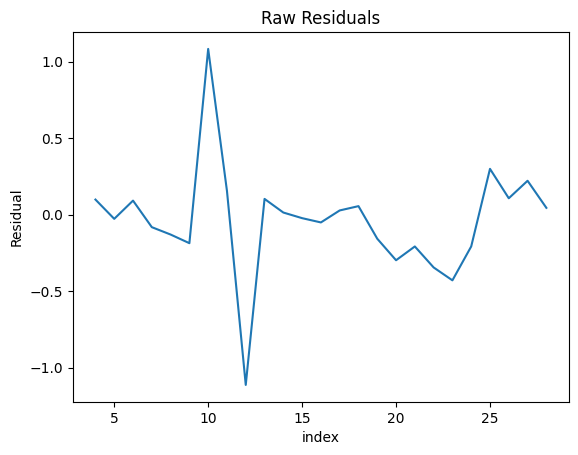

In [181]:
df['resid'] = df['log_count'] - df['log_expected']

plt.title('Raw Residuals')
plt.plot(df['resid'])
plt.xlabel('index')
plt.ylabel('Residual')
plt.show()

I confirmed that it was lead that represented the huge swing as seen in here.  Both a massive +1 and -1 in a logarithm scaled value, so a swing of roughly an order of magnitude (though I used $ln$, not $log_{10}$).

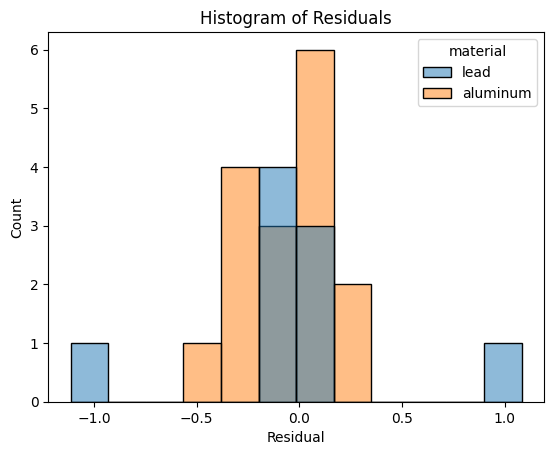

In [182]:
sns.histplot(data=df.dropna(), x=df['resid'], hue='material')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.show()

Those two lead outliers at +/- 1 do seem very out of place here.  Either I could drop those two, or the entire set of data from that last point of thickness.

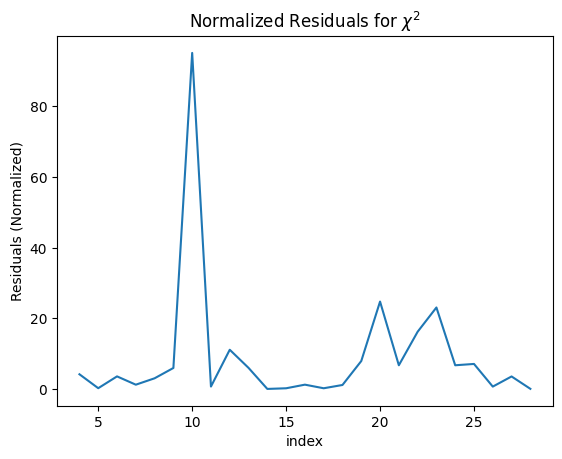

In [183]:
df['resid_norm'] = ((df['log_count'] - df['log_expected']) / df['unc_log_count'])**2

plt.title('Normalized Residuals for $\chi^2$')
plt.plot(df['resid_norm'])
plt.xlabel('index')
plt.ylabel('Residuals (Normalized)')
plt.show()

In [184]:
df

,material,thickness (cm),count,log_count,unc_count,unc_log_count,log_expected,resid,resid_norm
0,none,0.00000,787,6.668228,28.053520,0.035646,NaN,NaN,NaN
1,none,0.00000,771,6.647688,27.766887,0.036014,NaN,NaN,NaN
2,none,0.00000,737,6.602588,27.147744,0.036835,NaN,NaN,NaN
3,none,0.00000,764,6.638568,27.640550,0.036179,NaN,NaN,NaN
4,lead,0.61725,439,6.084499,20.952327,0.047727,5.986291,0.098208,4.234079
5,lead,0.61725,387,5.958425,19.672316,0.050833,5.986291,-0.027867,0.300525
6,lead,0.61725,436,6.077642,20.880613,0.047891,5.986291,0.091351,3.638415
7,lead,1.26150,191,5.252273,13.820275,0.072357,5.334510,-0.082237,1.291708
8,lead,1.26150,182,5.204007,13.490738,0.074125,5.334510,-0.130503,3.099668
9,lead,1.26150,172,5.147494,13.114877,0.076249,5.334510,-0.187016,6.015673
